# Introduction
- nb45の編集
- fc 特徴量を作成する

# Import everything I need :)

In [1]:
import warnings
import time
import multiprocessing
import glob
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from fastprogress import progress_bar

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Preparation

In [2]:
nb = 47
isSmallSet = False
length = 20000

In [3]:
pd.set_option('display.max_columns', 200)
warnings.filterwarnings('ignore')

In [4]:
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [5]:
file_path = '../input/champs-scalar-coupling/'
glob.glob(file_path + '*')

['../input/champs-scalar-coupling/nb29_fc_train_feature.csv',
 '../input/champs-scalar-coupling/train_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/mulliken_charges.csv',
 '../input/champs-scalar-coupling/nb33_train_dist-interaction.csv',
 '../input/champs-scalar-coupling/test_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/structures.csv',
 '../input/champs-scalar-coupling/magnetic_shielding_tensors.csv',
 '../input/champs-scalar-coupling/train.csv',
 '../input/champs-scalar-coupling/dipole_moments.csv',
 '../input/champs-scalar-coupling/test.csv',
 '../input/champs-scalar-coupling/nb29_fc_test_feature.csv',
 '../input/champs-scalar-coupling/scalar_coupling_contributions.csv',
 '../input/champs-scalar-coupling/potential_energy.csv',
 '../input/champs-scalar-coupling/sample_submission.csv',
 '../input/champs-scalar-coupling/nb33_test_dist-interaction.csv']

In [6]:
# train
path = file_path + 'train.csv'
if isSmallSet:
    train = pd.read_csv(path) [:length]
else:
    train = pd.read_csv(path)

In [7]:
# test
path = file_path + 'test.csv'
if isSmallSet:
    test = pd.read_csv(path)[:length]
else:
    test = pd.read_csv(path)

In [8]:
# structure
path = file_path + 'structures.csv'
structures = pd.read_csv(path)

In [127]:
# scalar_coupling_contributions
path = file_path + 'scalar_coupling_contributions.csv'
if isSmallSet:
    fc = pd.read_csv(path)['fc'][:length]
else:
    fc = pd.read_csv(path)['fc']

In [10]:
# train dist-interact
path = file_path + 'nb33_train_dist-interaction.csv'
if isSmallSet:
    dist_interact_train = pd.read_csv(path)[:length]
else:
    dist_interact_train = pd.read_csv(path)

In [11]:
# test dist-interact
path = file_path + 'nb33_test_dist-interaction.csv'
if isSmallSet:
    dist_interact_test = pd.read_csv(path)[:length]
else:
    dist_interact_test = pd.read_csv(path)

In [12]:
# ob charge train
path = file_path + 'train_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv'
if isSmallSet:
    ob_charge_train = pd.read_csv(path)[:length].drop(['Unnamed: 0', 'error'], axis=1)
else:
    ob_charge_train = pd.read_csv(path).drop(['Unnamed: 0', 'error'], axis=1)

In [13]:
# ob charge test
path = file_path + 'test_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv'
if isSmallSet:
    ob_charge_test = pd.read_csv(path)[:length].drop(['Unnamed: 0', 'error'], axis=1)
else:
    ob_charge_test = pd.read_csv(path).drop(['Unnamed: 0', 'error'], axis=1)

In [14]:
if isSmallSet:
    print('using SmallSet !!')
    print('-------------------')

print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {train['atom_index_0'].nunique()} unique atoms.")
print(f"There are {train['type'].nunique()} unique types.")

There are 4658147 rows in train data.
There are 2505542 rows in test data.
There are 85003 distinct molecules in train data.
There are 45772 distinct molecules in test data.
There are 29 unique atoms.
There are 8 unique types.


---
## myFunc
**metrics**

In [69]:
def kaggle_metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

---
**momory**

In [16]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Feature Engineering

Build Distance Dataset

In [17]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_name'].isin(base['molecule_name'])]
    return base, structures

#  a,b = build_type_dataframes(train, structures, '1JHN')

In [18]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_name', f'atom_index_{index}'],
                  right_on=['molecule_name', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [19]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_name', 'atom_index_0', 'atom_index_1'])
    return df

In [20]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_name'],
                  right_on=['molecule_name'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [21]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [22]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [23]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_name'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_name', right_index=True)

In [24]:
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_name', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_name', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_name', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
#     # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
#     atoms['molecule_name'] = atoms['molecule_name'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [25]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = ['id', 'molecule_name', 'atom_index_1', 'atom_index_0']
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    return df[labels]

In [26]:
atoms = structures['atom'].values
types_train = train['type'].values
types_test = test['type'].values
structures['atom'] = structures['atom'].replace(ATOMIC_NUMBERS).astype('int8')
fulls_train = []
fulls_test  = []
for type_ in progress_bar(train['type'].unique()):
    full_train = build_couple_dataframe(train, structures, type_, n_atoms=10)
    full_test  = build_couple_dataframe(test, structures, type_, n_atoms=10)
    full_train = take_n_atoms(full_train, 10)
    full_test  = take_n_atoms(full_test, 10)
    fulls_train.append(full_train)
    fulls_test.append(full_test)
    
structures['atom'] = atoms
train = pd.concat(fulls_train).sort_values(by=['id']) #, axis=0)
test  = pd.concat(fulls_test).sort_values(by=['id']) #, axis=0)
train['type'] = types_train
test['type'] = types_test
train = train.fillna(0)
test  = test.fillna(0)

<br>
<br>
dist-interact

In [27]:
train['dist_interact'] = dist_interact_train.values
test['dist_interact'] = dist_interact_test.values

<br>
<br>
basic

In [28]:
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)
    return df


# structure and ob_charges
ob_charge = pd.concat([ob_charge_train, ob_charge_test])
merge = pd.merge(ob_charge, structures, how='left',
                  left_on  = ['molecule_name', 'atom_index'],
                  right_on = ['molecule_name', 'atom_index'])
for atom_idx in [0,1]:
    train = map_atom_info(train, merge, atom_idx)
    test  = map_atom_info(test,  merge, atom_idx)
    
    train = train.rename(columns={
                                        'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}',
                                        'eem': f'eem_{atom_idx}',
                                     'mmff94': f'mmff94_{atom_idx}',
                                  'gasteiger': f'gasteiger_{atom_idx}', 
                                        'qeq': f'qeq_{atom_idx}',
                                      'qtpie': f'qtpie_{atom_idx}', 
                                  'eem2015ha': f'eem2015ha_{atom_idx}', 
                                  'eem2015hm': f'eem2015hm_{atom_idx}', 
                                  'eem2015hn': f'eem2015hn_{atom_idx}', 
                                  'eem2015ba': f'eem2015ba_{atom_idx}', 
                                  'eem2015bm': f'eem2015bm_{atom_idx}', 
                                  'eem2015bn': f'eem2015bn_{atom_idx}',})
    test = test.rename(columns={
                                        'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}',
                                        'eem': f'eem_{atom_idx}',
                                     'mmff94': f'mmff94_{atom_idx}',
                                  'gasteiger': f'gasteiger_{atom_idx}', 
                                        'qeq': f'qeq_{atom_idx}', 
                                      'qtpie': f'qtpie_{atom_idx}', 
                                  'eem2015ha': f'eem2015ha_{atom_idx}', 
                                  'eem2015hm': f'eem2015hm_{atom_idx}', 
                                  'eem2015hn': f'eem2015hn_{atom_idx}', 
                                  'eem2015ba': f'eem2015ba_{atom_idx}', 
                                  'eem2015bm': f'eem2015bm_{atom_idx}', 
                                  'eem2015bn': f'eem2015bn_{atom_idx}'})
#     test  =  test.rename(columns={'atom': f'atom_{atom_idx}',
#                                         'x': f'x_{atom_idx}',
#                                         'y': f'y_{atom_idx}',
#                                         'z': f'z_{atom_idx}'})

# ob_charges
# train = map_atom_info(train, ob_charge_train, 0)
# test  = map_atom_info(test,  ob_charge_test,  0)
# train = map_atom_info(train, ob_charge_train, 1)
# test  = map_atom_info(test,  ob_charge_test,  1)

<br>
<br>
type0

In [29]:
def create_type0(df):
    df['type_0'] = df['type'].apply(lambda x : x[0])
    return df
# train['type_0'] = train['type'].apply(lambda x: x[0])
# test['type_0'] = test['type'].apply(lambda x: x[0])

<br>
<br>
distances

In [30]:
def distances(df):
    df_p_0 = df[['x_0', 'y_0', 'z_0']].values
    df_p_1 = df[['x_1', 'y_1', 'z_1']].values
    
    df['dist'] = np.linalg.norm(df_p_0 - df_p_1, axis=1)
    df['dist_x'] = (df['x_0'] - df['x_1']) ** 2
    df['dist_y'] = (df['y_0'] - df['y_1']) ** 2
    df['dist_z'] = (df['z_0'] - df['z_1']) ** 2
    
    return df

# train = distances(train)
# test  = distances(test)

<br>
<br>
統計量

In [31]:
def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']
    
    # fc
#     df[f'molecule_type_fc_max'] = df.groupby(['molecule_name', 'type'])['fc'].transform('max')
#     df[f'molecule_type_fc_min'] = df.groupby(['molecule_name', 'type'])['fc'].transform('min')
#     df[f'molecule_type_fc_std'] = df.groupby(['molecule_name', 'type'])['fc'].transform('std')
#     df[f'molecule_type_fc_std_diff'] = df[f'molecule_type_fc_std'] - df['fc']

    # dist-interact
    df[f'molecule_atom_index_0_dist_interact_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist_interact'].transform('mean')
    df[f'molecule_atom_index_0_dist_interact_mean_diff'] = df[f'molecule_atom_index_0_dist_interact_mean'] - df['dist_interact']
    df[f'molecule_atom_index_0_dist_interact_mean_div'] = df[f'molecule_atom_index_0_dist_interact_mean'] / df['dist_interact']
    df[f'molecule_atom_index_0_dist_interact_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist_interact'].transform('max')
    df[f'molecule_atom_index_0_dist_interact_max_diff'] = df[f'molecule_atom_index_0_dist_interact_max'] - df['dist_interact']
    df[f'molecule_atom_index_0_dist_interact_max_div'] = df[f'molecule_atom_index_0_dist_interact_max'] / df['dist_interact']
    df[f'molecule_atom_index_0_dist_interact_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist_interact'].transform('min')
    df[f'molecule_atom_index_0_dist_interact_min_diff'] = df[f'molecule_atom_index_0_dist_interact_min'] - df['dist_interact']
    df[f'molecule_atom_index_0_dist_interact_min_div'] = df[f'molecule_atom_index_0_dist_interact_min'] / df['dist_interact']
    df[f'molecule_atom_index_0_dist_interact_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist_interact'].transform('std')
    df[f'molecule_atom_index_0_dist_interact_std_diff'] = df[f'molecule_atom_index_0_dist_interact_std'] - df['dist_interact']
    df[f'molecule_atom_index_0_dist_interact_std_div'] = df[f'molecule_atom_index_0_dist_interact_std'] / df['dist_interact']
    df[f'molecule_atom_index_1_dist_interact_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist_interact'].transform('mean')
    df[f'molecule_atom_index_1_dist_interact_mean_diff'] = df[f'molecule_atom_index_1_dist_interact_mean'] - df['dist_interact']
    df[f'molecule_atom_index_1_dist_interact_mean_div'] = df[f'molecule_atom_index_1_dist_interact_mean'] / df['dist_interact']
    df[f'molecule_atom_index_1_dist_interact_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist_interact'].transform('max')
    df[f'molecule_atom_index_1_dist_interact_max_diff'] = df[f'molecule_atom_index_1_dist_interact_max'] - df['dist_interact']
    df[f'molecule_atom_index_1_dist_interact_max_div'] = df[f'molecule_atom_index_1_dist_interact_max'] / df['dist_interact']
    df[f'molecule_atom_index_1_dist_interact_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist_interact'].transform('min')
    df[f'molecule_atom_index_1_dist_interact_min_diff'] = df[f'molecule_atom_index_1_dist_interact_min'] - df['dist_interact']
    df[f'molecule_atom_index_1_dist_interact_min_div'] = df[f'molecule_atom_index_1_dist_interact_min'] / df['dist_interact']
    df[f'molecule_atom_index_1_dist_interact_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist_interact'].transform('std')
    df[f'molecule_atom_index_1_dist_interact_std_diff'] = df[f'molecule_atom_index_1_dist_interact_std'] - df['dist_interact']
    df[f'molecule_atom_index_1_dist_interact_std_div'] = df[f'molecule_atom_index_1_dist_interact_std'] / df['dist_interact']
    df[f'molecule_type_dist_interact_max'] = df.groupby(['molecule_name', 'type'])['dist_interact'].transform('max')
    df[f'molecule_type_dist_interact_min'] = df.groupby(['molecule_name', 'type'])['dist_interact'].transform('min')
    df[f'molecule_type_dist_interact_std'] = df.groupby(['molecule_name', 'type'])['dist_interact'].transform('std')
    df[f'molecule_type_dist_interact_std_diff'] = df[f'molecule_type_dist_interact_std'] - df['dist_interact']
    
    return df

<br>
<br>
angle features

In [32]:
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)

    return df

def create_closest(df):
    df_temp=df.loc[:,["molecule_name","atom_index_0","atom_index_1","dist","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
    df_temp_=df_temp.copy()
    df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
    df_temp=pd.concat(objs=[df_temp,df_temp_],axis=0)

    df_temp["min_distance"]=df_temp.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df_temp= df_temp[df_temp["min_distance"]==df_temp["dist"]]

    df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance', 'dist'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                     'atom_index_1': 'atom_index_closest',
                                     'distance': 'distance_closest',
                                     'x_1': 'x_closest',
                                     'y_1': 'y_closest',
                                     'z_1': 'z_closest'})

    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})
    return df

def add_cos_features(df):
    df["distance_0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["distance_1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["vec_0_x"]=(df['x_0']-df['x_closest_0'])/df["distance_0"]
    df["vec_0_y"]=(df['y_0']-df['y_closest_0'])/df["distance_0"]
    df["vec_0_z"]=(df['z_0']-df['z_closest_0'])/df["distance_0"]
    df["vec_1_x"]=(df['x_1']-df['x_closest_1'])/df["distance_1"]
    df["vec_1_y"]=(df['y_1']-df['y_closest_1'])/df["distance_1"]
    df["vec_1_z"]=(df['z_1']-df['z_closest_1'])/df["distance_1"]
    df["vec_x"]=(df['x_1']-df['x_0'])/df["dist"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["dist"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["dist"]
    df["cos_0_1"]=df["vec_0_x"]*df["vec_1_x"]+df["vec_0_y"]*df["vec_1_y"]+df["vec_0_z"]*df["vec_1_z"]
    df["cos_0"]=df["vec_0_x"]*df["vec_x"]+df["vec_0_y"]*df["vec_y"]+df["vec_0_z"]*df["vec_z"]
    df["cos_1"]=df["vec_1_x"]*df["vec_x"]+df["vec_1_y"]*df["vec_y"]+df["vec_1_z"]*df["vec_z"]
    df=df.drop(['vec_0_x','vec_0_y','vec_0_z','vec_1_x','vec_1_y','vec_1_z','vec_x','vec_y','vec_z'], axis=1)
    return df



In [33]:
%%time

print('type0')
print(len(train), len(test))
train = create_type0(train)
test  = create_type0(test)

print('distances')
print(len(train), len(test))
train = distances(train)
test  = distances(test)

print('create_featueres')
print(len(train), len(test))
train = create_features(train)
test  = create_features(test)

print('create_closest')
print(len(train), len(test))
train = create_closest(train)
test  = create_closest(test)
train.drop_duplicates(inplace=True, subset=['id'])   # なぜかtrainの行数が増えるバグが発生

print('add_cos_features')
print(len(train), len(test))
train = add_cos_features(train)
test  = add_cos_features(test)

type0
4658147 2505542
distances
4658147 2505542
create_featueres
4658147 2505542
create_closest
4658147 2505542
add_cos_features
4658147 2505542
CPU times: user 2min 58s, sys: 4min 35s, total: 7min 34s
Wall time: 7min 34s


---
<br>
<br>
LabelEncode

- `atom_1` = {H, C, N}
- `type_0` = {1, 2, 3}
- `type`   = {2JHC, ...}

In [34]:
for f in ['atom_1', 'type_0', 'type']:
    if f in train.columns:
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

---
**show features**

In [35]:
train.head(2)

,id,molecule_name,atom_index_1,atom_index_0,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3,scalar_coupling_constant,type,dist_interact,eem_0,mmff94_0,gasteiger_0,qeq_0,qtpie_0,eem2015ha_0,eem2015hm_0,eem2015hn_0,eem2015ba_0,eem2015bm_0,eem2015bn_0,atom_0,x_0,y_0,z_0,eem_1,mmff94_1,gasteiger_1,qeq_1,qtpie_1,eem2015ha_1,eem2015hm_1,eem2015hn_1,eem2015ba_1,eem2015bm_1,eem2015bn_1,atom_1,x_1,y_1,z_1,type_0,dist,dist_x,dist_y,dist_z,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_x_1_std,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_mean_div,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_y_1_std,molecule_atom_index_0_z_1_std,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,molecule_type_0_dist_std,molecule_type_0_dist_std_diff,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,molecule_type_dist_std,molecule_type_dist_std_diff,molecule_atom_index_0_dist_interact_mean,molecule_atom_index_0_dist_interact_mean_diff,molecule_atom_index_0_dist_interact_mean_div,molecule_atom_index_0_dist_interact_max,molecule_atom_index_0_dist_interact_max_diff,molecule_atom_index_0_dist_interact_max_div,molecule_atom_index_0_dist_interact_min,molecule_atom_index_0_dist_interact_min_diff,molecule_atom_index_0_dist_interact_min_div,molecule_atom_index_0_dist_interact_std,molecule_atom_index_0_dist_interact_std_diff,molecule_atom_index_0_dist_interact_std_div,molecule_atom_index_1_dist_interact_mean,molecule_atom_index_1_dist_interact_mean_diff,molecule_atom_index_1_dist_interact_mean_div,molecule_atom_index_1_dist_interact_max,molecule_atom_index_1_dist_interact_max_diff,molecule_atom_index_1_dist_interact_max_div,molecule_atom_index_1_dist_interact_min,molecule_atom_index_1_dist_interact_min_diff,molecule_atom_index_1_dist_interact_min_div,molecule_atom_index_1_dist_interact_std,molecule_atom_index_1_dist_interact_std_diff,molecule_atom_index_1_dist_interact_std_div,molecule_type_dist_interact_max,molecule_type_dist_interact_min,molecule_type_dist_interact_std,molecule_type_dist_interact_std_diff,atom_index_closest_0,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1
0,0,dsgdb9nsd_000001,0,1,1,1,1,0,0,0,0,0,1.091953,1.783120,1.091952,1.783147,1.091946,1.783158,1.783157,1.091948,1.783148,1.783148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.8076,0,1.091953,0.161131,0.0,0.019399,-0.812772,0.773439,-0.003651,0.203254,0.196234,0.016837,0.201583,0.212813,H,0.00215,-0.006031,0.001976,-0.644531,0.0,-0.077596,3.251140,-3.093807,0.014606,-0.813021,-0.784944,-0.067349,-0.806339,-0.851258,0,-0

In [36]:
print(train.columns)

Index(['id', 'molecule_name', 'atom_index_1', 'atom_index_0', 'atom_2',
       'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7',
       ...
       'z_closest_0', 'atom_index_closest_1', 'x_closest_1', 'y_closest_1',
       'z_closest_1', 'distance_0', 'distance_1', 'cos_0_1', 'cos_0', 'cos_1'],
      dtype='object', length=174)


# create train, test data

In [37]:
y = fc
train = train.drop(['id', 'molecule_name', 'atom_0', 'scalar_coupling_constant'], axis=1)
test  =  test.drop(['id', 'molecule_name', 'atom_0'], axis=1)
train = reduce_mem_usage(train)
test  = reduce_mem_usage(test)

X = train.copy()
X_test = test.copy()

assert len(X.columns) == len(X_test.columns), f'X と X_test のサイズが違います X: {len(X.columns)}, X_test: {len(X_test.columns)}'

Mem. usage decreased to 5521.85 Mb (5.3% reduction)
Mem. usage decreased to 2970.11 Mb (5.3% reduction)


In [38]:
del train, test, full_train, full_test

In [39]:
gc.collect()

103

# Training model

**params**

In [46]:
# Configuration
TARGET = 'scalar_coupling_constant'
CAT_FEATS = ['type']
N_ESTIMATORS = 4000
VERBOSE = 400
EARLY_STOPPING_ROUNDS = 200
RANDOM_STATE = 529
METRIC = mean_absolute_error
N_JOBS = multiprocessing.cpu_count() -10

# lightgbm params
lgb_params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }


In [47]:
# init

def train_lgb(X, X_test, y, lgb_params, folds,
              verbose, early_stopping_rounds, n_estimators, categorical_feature=None):

    result_dict = {}
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    models = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
        print('------------------')
        print(f'- fold{fold_n + 1}' )
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
#         from IPython.core.debugger import Pdb; Pdb().set_trace()
        

        # Train the model
        model = lgb.LGBMRegressor(**lgb_params, n_estimators=n_estimators, n_jobs=N_JOBS)
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  verbose=verbose,
                  early_stopping_rounds=early_stopping_rounds,
                  categorical_feature=CAT_FEATS)

        # predict
        y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration_)   
        y_test_pred = model.predict(X_test)

        oof[valid_idx] = y_valid_pred.reshape(-1,)  # oof: out of folds
        scores.append(mean_absolute_error(y_valid, y_valid_pred))

        prediction += y_test_pred

        # feature_importance
        fold_importance = pd.DataFrame()
        fold_importance['feature'] = X.columns
        fold_importance['importance'] = model.feature_importances_
        fold_importance['fold'] = fold_n + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    # result
    prediction /= folds.n_splits
    feature_importance["importance"] /= folds.n_splits
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    result_dict['feature_importance'] = feature_importance


    print('------------------')
    print('====== finish ======')
    print('score list:', scores)
    X['scalar_coupling_constant'] = y
    cv_score = kaggle_metric(X, oof)
#     X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)
    print('CV mean score(group log mae): {0:.4f}'.format(cv_score))

    
    return result_dict, cv_score

In [48]:
n_folds = 5
folds = KFold(n_splits=n_folds, shuffle=True)

In [49]:
X.shape, y.shape, X_test.shape

((4658147, 170), (4658147,), (2505542, 170))

In [77]:
X.columns[np.isnan(X).any()]

Index(['dist_interact', 'molecule_atom_index_0_x_1_std',
       'molecule_atom_index_0_y_1_mean_div', 'molecule_atom_index_0_y_1_std',
       'molecule_atom_index_0_z_1_std', 'molecule_atom_index_0_dist_std',
       'molecule_atom_index_0_dist_std_diff',
       'molecule_atom_index_0_dist_std_div', 'molecule_atom_index_1_dist_std',
       'molecule_atom_index_1_dist_std_diff',
       'molecule_atom_index_1_dist_std_div', 'molecule_atom_1_dist_std',
       'molecule_atom_1_dist_std_diff', 'molecule_type_0_dist_std',
       'molecule_type_0_dist_std_diff', 'molecule_type_dist_std',
       'molecule_type_dist_std_diff',
       'molecule_atom_index_0_dist_interact_mean_diff',
       'molecule_atom_index_0_dist_interact_mean_div',
       'molecule_atom_index_0_dist_interact_max_diff',
       'molecule_atom_index_0_dist_interact_max_div',
       'molecule_atom_index_0_dist_interact_min_diff',
       'molecule_atom_index_0_dist_interact_min_div',
       'molecule_atom_index_0_dist_interact_st

In [50]:
%%time
# type ごとの学習 

feature_importance  = pd.DataFrame()
X_short = pd.DataFrame({'ind': list(X.index), 'type': X['type'].values, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': X_test['type'].values, 'prediction': [0] * len(X_test)})
for t in X['type'].unique():
    print('')
    print('*'*100)
    print(f'Training of type {lbl.inverse_transform([t])[0]}({t})')
    print('*'*100)
    X_t = X.loc[X['type'] == t]
    X_test_t = X_test.loc[X_test['type'] == t]
    y_t = X_short.loc[X_short['type'] == t, 'target'].values
#     from IPython.core.debugger import Pdb; Pdb().set_trace()

#     result_dict_lgb3 = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=False,
#                                                       verbose=500, early_stopping_rounds=200, n_estimators=3000)
    result_dict, cv_score = train_lgb(X=X_t, X_test=X_test_t, y=y_t, folds=folds, lgb_params=lgb_params,
                            verbose=VERBOSE, early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                            n_estimators=N_ESTIMATORS,
                            categorical_feature=CAT_FEATS)
    X_short.loc[X_short['type'] == t, 'oof'] = result_dict['oof']
    X_short_test.loc[X_short_test['type'] == t, 'prediction'] = result_dict['prediction']
    
    feature_importance = pd.concat([feature_importance, result_dict['feature_importance']], axis=0)
    

print('')
print('===== finish =====')
X['scalar_coupling_constant'] = fc.values
metric = kaggle_metric(X, X_short['oof'].values)
X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)
print('CV mean score(group log mae): {0:.4f}'.format(metric))
fc_pred_test  = X_short_test['prediction'].values
fc_pred_train = X_short['oof'].values
# X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)
# sub['scalar_coupling_constant'] = X_short_test['prediction']
# sub.to_csv('submission_t.csv', index=False)
# sub.head()


****************************************************************************************************
Training of type 1JHC(0)
****************************************************************************************************
------------------
- fold1
Fold 1 started at Wed Aug 21 04:26:57 2019
Training until validation scores don't improve for 200 rounds.
[400]	training's l1: 0.727496	valid_1's l1: 0.888786
[800]	training's l1: 0.555156	valid_1's l1: 0.803788
[1200]	training's l1: 0.453738	valid_1's l1: 0.766603
[1600]	training's l1: 0.381479	valid_1's l1: 0.745283
[2000]	training's l1: 0.326903	valid_1's l1: 0.731901
[2400]	training's l1: 0.282409	valid_1's l1: 0.72192
[2800]	training's l1: 0.246383	valid_1's l1: 0.715028
[3200]	training's l1: 0.215974	valid_1's l1: 0.709846
[3600]	training's l1: 0.190454	valid_1's l1: 0.705817
[4000]	training's l1: 0.168608	valid_1's l1: 0.702648
Did not meet early stopping. Best iteration is:
[4000]	training's l1: 0.168608	valid_1's l1: 0.702648


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [157]:
print('CV mean score(group log mae): {0:.4f}'.format(metric))

CV mean score(group log mae): -1.4012


## plot feature importance

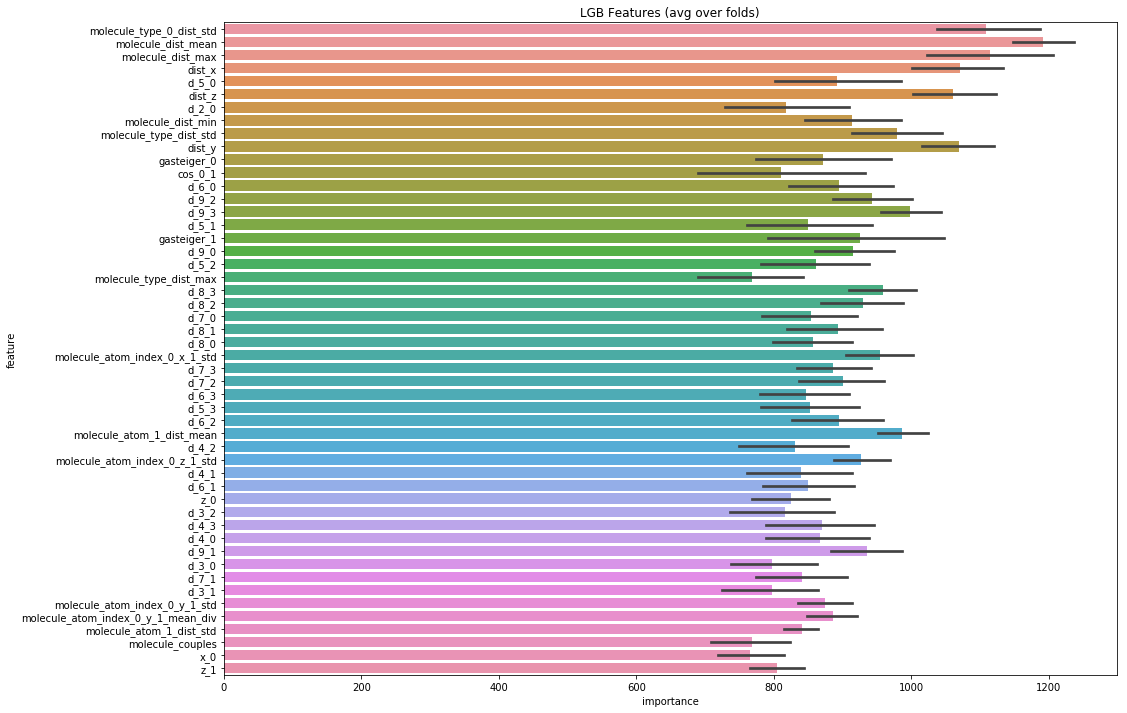

In [158]:
# top 50 features
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

# Save

test

In [159]:
# path_submittion = './output/' + 'nb{}_submission_lgb_{}.csv'.format(nb, metric)
path = f'../input/champs-scalar-coupling/nb{nb}_fc_test.csv'
print(f'save pash: {path}')

save pash: ../input/champs-scalar-coupling/nb47_fc_test.csv


In [160]:
_ = pd.DataFrame({'fc': fc_pred_test})
if isSmallSet:
    print('using small datasets')
else:
    _.to_csv(path, index=False)

<br>
<br>
train

In [161]:
# path_submittion = './output/' + 'nb{}_submission_lgb_{}.csv'.format(nb, metric)
path = f'../input/champs-scalar-coupling/nb{nb}_fc_train.csv'
print(f'save pash: {path}')

save pash: ../input/champs-scalar-coupling/nb47_fc_train.csv


In [162]:
_ = pd.DataFrame({'fc': fc_pred_train})
if isSmallSet:
    print('using small datasets')
else:
    _.to_csv(path, index=False)

# analysis

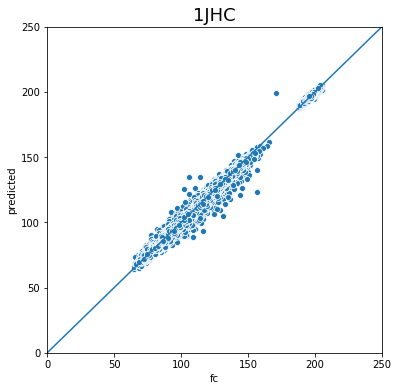

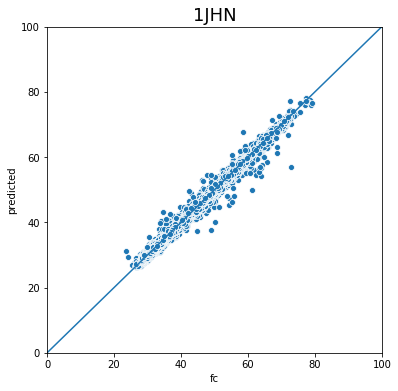

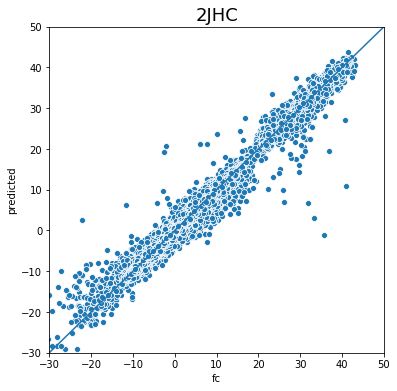

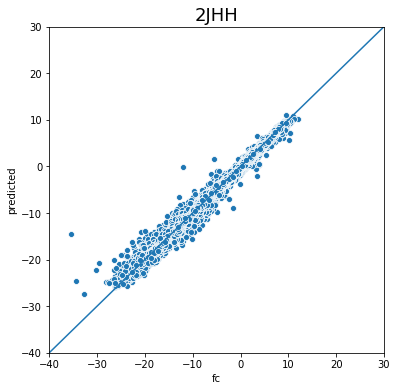

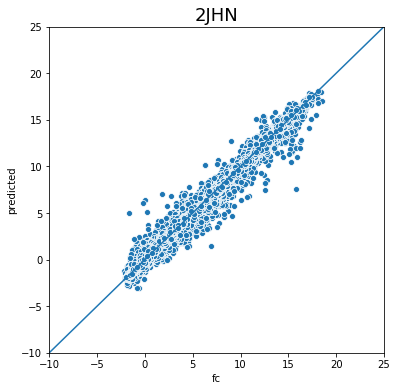

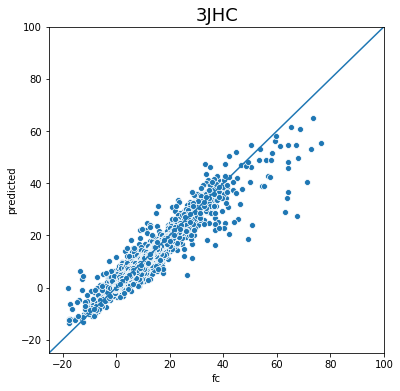

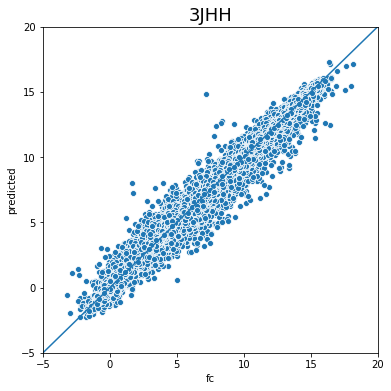

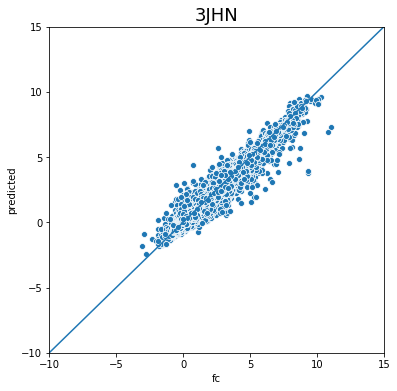

In [163]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = X_short['oof']
plot_data['type'] = lbl.inverse_transform(X['type'])

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='fc',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['fc', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('fc')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -30, 50)
plot_oof_preds('2JHH', -40, 30)
plot_oof_preds('2JHN', -10, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -5, 20)
plot_oof_preds('3JHN', -10, 15)